# Generate explanation usecase: user_id=13

About: Model-based recsys trained on flat TF-IDF

Workflow:
- Load ranking result (by model-based recsys: logreg, dt, etc)
- Filter result only for user_id = 13 (max 20 applications)
- Get local post-hoc explaination
    - Generate LIME_local explaination for this user (using LIME library): This will be a loop as LIME need to explain by row
    - Generate LIME_local explaination for this user (using interpret library for comparison)
    - Generate SHAP_kernel explaination for this user (using SHAP library)
- Get index of job_matrix, word_history_matrix from feature importance
- Retrieved words from the original corpus: these are key words to explain the decision

**NOTE: Interactive plots for LIME and LIME (interpretml) will not saved after closing notebook.**

In [1]:
import caffeine
caffeine.on(display=False)

In [13]:
# Run this for reproduce
# Gets the current working directory
import os
cwd = os.getcwd()
print("Working directory:", cwd)
# Go up one directory from working directory
os.chdir("..")

Working directory: /Users/anhtth/Library/CloudStorage/OneDrive-UniversityofTwente/2023 UT- THESIS/1-Code/0.cb12_main/nb_xai_viz


In [3]:
# Import library for baseline classification models
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

In [4]:
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())

In [5]:
from interpret import show
from interpret.blackbox import LimeTabular

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from sklearn import metrics

In [7]:
import matplotlib.pyplot as plt

In [8]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
# !pip install numpy==1.24

In [10]:
import shap
shap.initjs()

In [11]:
import lime
import lime.lime_tabular

# Load input data

In [14]:
# Load input: train_data_flat, test_data_flat
train_data_flat = pd.read_csv('./xai_posthoc/train_data_flat.csv')
test_data_flat = pd.read_csv('./xai_posthoc/test_data_flat.csv')

drop_cols_flat = ['UserID','JobID', 'label','u_idx','j_idx',
                  'work_history_matrix', 'job_matrix', 
                  'mean_work_history_matrix', 'mean_job_matrix', 
                  'flat_work_history', 'flat_job']
X_train = train_data_flat.drop(columns = drop_cols_flat, axis = 1)
X_test = test_data_flat.drop(columns = drop_cols_flat, axis = 1)

y_train = np.load("./xai_posthoc/y_train_tabular.npy")
y_test = np.load("./xai_posthoc/y_test_tabular.npy")

In [15]:
# Load a baseline model
import pickle
model = 'logreg'
model_name = './output_baseline_tabular/cb12_logreg_flat.pikle'
logreg = pickle.load(open(model_name, "rb"))

In [16]:
# Load pre-processed data
path = "./data_processed/"
user_set = pd.read_csv(path +"users_clean.csv")
job_set = pd.read_csv(path + "jobset_clean.csv")
work_history = pd.read_csv(path + "work_history.csv") 
dataset = pd.read_csv(path + "dataset.csv") #negative sampling application data

In [17]:
# Create corpus by joining job Title, Description, and Requirement
job_set = job_set.fillna(" ")
job_set["word"] = job_set.Title + job_set.Description + job_set.Requirements

In [18]:
# Load TF-IDF vectorizer
import pickle
# For jobs: tf
tf_path = './data_interim_tfidf/job_tf.pickle'
tf = pickle.load(open(tf_path, "rb"))

# For work_history: word_history_tf
work_history_tf_path = './data_interim_tfidf/work_history_tf.pickle'
word_history_tf = pickle.load(open(work_history_tf_path, "rb"))

In [19]:
# Load TF-IDF matrix for jobs and user work history
from scipy import sparse 
tfidf_matrix = sparse.load_npz("./data_interim_tfidf/tfidf_matrix.npz")
word_history_tf_matrix = sparse.load_npz("./data_interim_tfidf/work_history_tf_matrix.npz")

In [20]:
tfidf_matrix.shape

(1050509, 100)

In [21]:
features_flat = pd.read_csv('./nb_recsys_tabular/features_flat_tfidf.csv')

# Preparation
- Get subset of recommendation for the given user_id
- Get raw terms for jobs tf_idf matrix
- Recommendation result and ranking data used to make the recommendation should be matched (eg: ranking_data_random or knn_ranking_tfidf)

In [22]:
# Load recommendation result by logreg model
model = 'logreg'
logreg_recommendations = pd.read_csv('./output_topN_tabular/result_knn_ranking_v2/rec_result_logreg_ranking_v2.csv')

In [23]:
# Load ranking data (generated by KNN-TFIDF features)
ranking_data = pd.read_csv('./nb_ranking_data/knn_tfidf_ranking_v2.csv')

In [24]:
test_uid = 13

In [25]:
logreg_recommendations[logreg_recommendations.UserID==test_uid]

UserID    JobID    Y_prob  Y_pred  rank
0       13   248446  0.970798       1     0
1       13   367918  0.937227       1     1
2       13   580991  0.445008       0     2
3       13   172155  0.351762       0     3
4       13   799192  0.340405       0     4
5       13   241804  0.321821       0     5
6       13   872594  0.319501       0     6
7       13   876016  0.309969       0     7
8       13   602061  0.305032       0     8
9       13   979883  0.289789       0     9
10      13  1100319  0.277988       0    10
11      13   491220  0.275157       0    11
12      13   824471  0.260717       0    12
13      13   641999  0.256119       0    13
14      13   864858  0.242136       0    14
15      13   259223  0.241876       0    15
16      13   568514  0.239257       0    16
17      13   741104  0.233798       0    17
18      13   198371  0.223575       0    18
19      13   134765  0.221879       0    19

In [26]:
# Get feature names list 
location_features = ['City', 'State', 'Country', 'UserID', 'JobID'] # for matching location
user_profile_features = ["DegreeType", "WorkHistoryCount", "TotalYearsExperience", "CurrentlyEmployed", 
                                                "ManagedOthers", "ManagedHowMany"] # for user profile

# Get work_matrix_features
work_matrix_idx = range(50)
features_work_matrix = list(map(lambda x: 'work_matrix_' + str(x), work_matrix_idx))
# features_work_matrix.append('UserID')

# Get job_matrix_features
job_matrix_idx = range(100)
features_job_matrix = list(map(lambda x: 'job_matrix_' + str(x), job_matrix_idx))
features_job_matrix.append('JobID')

In [27]:
features_work_matrix

['work_matrix_0',
 'work_matrix_1',
 'work_matrix_2',
 'work_matrix_3',
 'work_matrix_4',
 'work_matrix_5',
 'work_matrix_6',
 'work_matrix_7',
 'work_matrix_8',
 'work_matrix_9',
 'work_matrix_10',
 'work_matrix_11',
 'work_matrix_12',
 'work_matrix_13',
 'work_matrix_14',
 'work_matrix_15',
 'work_matrix_16',
 'work_matrix_17',
 'work_matrix_18',
 'work_matrix_19',
 'work_matrix_20',
 'work_matrix_21',
 'work_matrix_22',
 'work_matrix_23',
 'work_matrix_24',
 'work_matrix_25',
 'work_matrix_26',
 'work_matrix_27',
 'work_matrix_28',
 'work_matrix_29',
 'work_matrix_30',
 'work_matrix_31',
 'work_matrix_32',
 'work_matrix_33',
 'work_matrix_34',
 'work_matrix_35',
 'work_matrix_36',
 'work_matrix_37',
 'work_matrix_38',
 'work_matrix_39',
 'work_matrix_40',
 'work_matrix_41',
 'work_matrix_42',
 'work_matrix_43',
 'work_matrix_44',
 'work_matrix_45',
 'work_matrix_46',
 'work_matrix_47',
 'work_matrix_48',
 'work_matrix_49']

## Build X_rec: Feature vector based on recommendation result
This will be use for local explanation

In [28]:
rec_data = logreg_recommendations[logreg_recommendations.UserID==test_uid].reset_index(drop=True)

In [29]:
rec_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   UserID  20 non-null     int64  
 1   JobID   20 non-null     int64  
 2   Y_prob  20 non-null     float64
 3   Y_pred  20 non-null     int64  
 4   rank    20 non-null     int64  
dtypes: float64(1), int64(4)
memory usage: 928.0 bytes


In [30]:
rec_data

UserID    JobID    Y_prob  Y_pred  rank
0       13   248446  0.970798       1     0
1       13   367918  0.937227       1     1
2       13   580991  0.445008       0     2
3       13   172155  0.351762       0     3
4       13   799192  0.340405       0     4
5       13   241804  0.321821       0     5
6       13   872594  0.319501       0     6
7       13   876016  0.309969       0     7
8       13   602061  0.305032       0     8
9       13   979883  0.289789       0     9
10      13  1100319  0.277988       0    10
11      13   491220  0.275157       0    11
12      13   824471  0.260717       0    12
13      13   641999  0.256119       0    13
14      13   864858  0.242136       0    14
15      13   259223  0.241876       0    15
16      13   568514  0.239257       0    16
17      13   741104  0.233798       0    17
18      13   198371  0.223575       0    18
19      13   134765  0.221879       0    19

In [31]:
u_id = test_uid
job_ids = rec_data[rec_data.UserID ==u_id].JobID.values

# Get full recommenation data and feature vector
- rec_full_data: contain both reccommendation results and features
- X_rec

In [32]:
def get_full_rec_data(u_id, rec_result):
    rec_data = rec_result[rec_result.UserID==u_id].reset_index(drop=True)
    
    # Filter location matching
    location_df = ranking_data[(ranking_data.UserID ==u_id) & (ranking_data.JobID.isin(job_ids))][location_features].reset_index(drop=True)
    
    # Filter job detail
    jobs_detail_df = features_flat[(features_flat.JobID.isin(job_ids))][features_job_matrix].drop_duplicates().reset_index(drop=True)
    
    # Get user work_history df
    work_history = pd.DataFrame(features_flat[features_flat.UserID==u_id][features_work_matrix].reset_index(drop=True).loc[0])
    work_history = work_history.T
    
    # Get user profile detail df
    user = pd.DataFrame(features_flat[features_flat.UserID==u_id][user_profile_features].reset_index(drop=True).loc[0])
    user = user.T
    
     # Repeat user profile and work_history for 20_rows df
    user_repeated = pd.DataFrame(np.repeat(user.values, 20, axis=0), columns=user.columns)
    work_history_repeated = pd.DataFrame(np.repeat(work_history.values, 20, axis=0), columns=work_history.columns)
    
    # Merge result: location matching, User profile, User history, Job detail
    rec_data_full = rec_data.merge(location_df, how='left', on=['JobID', 'UserID'])
    rec_data_full = pd.concat([rec_data_full, user_repeated, work_history_repeated], axis = 1)
    rec_data_full = rec_data_full.merge(jobs_detail_df, how='left', on='JobID')
    
    return rec_data_full
    

In [33]:
rec_data_full = get_full_rec_data(u_id = test_uid, 
                                   rec_result = logreg_recommendations)

In [34]:
rec_data_full

UserID    JobID    Y_prob  Y_pred  rank  City  State  Country  DegreeType  \
0       13   248446  0.970798       1     0   0.0    1.0      1.0         4.0   
1       13   367918  0.937227       1     1   0.0    1.0      1.0         4.0   
2       13   580991  0.445008       0     2   0.0    0.0      1.0         4.0   
3       13   172155  0.351762       0     3   0.0    0.0      1.0         4.0   
4       13   799192  0.340405       0     4   0.0    0.0      1.0         4.0   
5       13   241804  0.321821       0     5   0.0    0.0      1.0         4.0   
6       13   872594  0.319501       0     6   0.0    0.0      1.0         4.0   
7       13   876016  0.309969       0     7   0.0    0.0      1.0         4.0   
8       13   602061  0.305032       0     8   0.0    0.0      1.0         4.0   
9       13   979883  0.289789       0     9   0.0    0.0      1.0         4.0   
10      13  1100319  0.277988       0    10   0.0    0.0      1.0         4.0   
11      13   491220  0.275157       0    11   0.0    0.0      1.0         4.0   
12      13   824471  0.260717       0    12   0.0    0.0      1.0         4.0   
13      13   641999  0.256119       0    13   0.0    0.0      1.0         4.0   
14      13   864858  0.242136       0    14   0.0    0.0      1.0         4.0   
15      13   259223  0.241876       0    15   0.0    0.0      1.0         4.0   
16      13   568514  0.239257       0    16   0.0    0.0      1.0         4.0   
17      13   741104  0.233798       0    17   0.0    0.0      1.0         4.0   
18      13   198371  0.223575       0    18   0.0    0.0      1.0         4.0   
19      13   134765  0.221879       0    19   0.0    0.0      1.0         4.0   

    WorkHistoryCount  ...  job_matrix_90  job_matrix_91  job_matrix_92  \
0                6.0  ...       0.000000       0.042282       0.000000   
1                6.0  ...       0.000000       0.133810       0.597638   
2                6.0  ...       0.000000       0.000000       0.000000   
3                6.0  ...       0.000000       0.096150       0.000000   
4                6.0  ...       0.000000       0.000000       0.000000   
5                6.0  ...       0.000000       0.000000       0.000000   
6                6.0  ...       0.000000       0.155031       0.000000   
7                6.0  ...       0.000000       0.000000       0.000000   
8                6.0  ...       0.000000       0.000000       0.000000   
9                6.0  ...       0.268799       0.000000       0.000000   
10               6.0  ...       0.000000       0.000000       0.000000   
11               6.0  ...       0.000000       0.081079       0.000000   
12               6.0  ...       0.000000       0.061191       0.000000   
13               6.0  ...       0.283412       0.185379       0.000000   
14               6.0  ...       0.000000       0.113101       0.000000   
15               6.0  ...       0.000000       0.117821       0.000000   
16               6.0  ...       0.000000       0.000000       0.000000   
17               6.0  ...       0.000000       0.055386       0.000000   
18               6.0  ...       0.000000       0.000000       0.000000   
19               6.0  ...       0.000000       0.000000       0.000000   

    job_matrix_93  job_matrix_94  job_matrix_95  job_matrix_96  job_matrix_97  \
0        0.136861       0.000000       0.000000       0.250736       0.104661   
1        0.000000       0.148084       0.000000       0.226717       0.165611   
2        0.000000       0.109010       0.000000       0.166895       0.365738   
3        0.000000       0.106406       0.000000       0.244363       0.000000   
4        0.000000       0.000000       0.000000       0.000000       0.000000   
5        0.000000       0.000000       0.000000       0.075539       0.000000   
6        0.000000       0.171569       0.000000       0.131337       0.383752   
7        0.000000       0.000000       0.000000       0.080170       0.000000   
8        0.000000 

In [35]:
# Filter true label of application based on UserID and JobID => Result may not have same order of JobID
filtered_ranking_data = ranking_data[(ranking_data.UserID ==test_uid) & (ranking_data.JobID.isin(job_ids))].drop(['UserID','City','State','Country'], axis=1)

In [36]:
# Merge true label to rec_data
rec_data_full = rec_data_full.merge(filtered_ranking_data, how='left', on='JobID')

In [37]:
rec_data_full

UserID    JobID    Y_prob  Y_pred  rank  City  State  Country  DegreeType  \
0       13   248446  0.970798       1     0   0.0    1.0      1.0         4.0   
1       13   367918  0.937227       1     1   0.0    1.0      1.0         4.0   
2       13   580991  0.445008       0     2   0.0    0.0      1.0         4.0   
3       13   172155  0.351762       0     3   0.0    0.0      1.0         4.0   
4       13   799192  0.340405       0     4   0.0    0.0      1.0         4.0   
5       13   241804  0.321821       0     5   0.0    0.0      1.0         4.0   
6       13   872594  0.319501       0     6   0.0    0.0      1.0         4.0   
7       13   876016  0.309969       0     7   0.0    0.0      1.0         4.0   
8       13   602061  0.305032       0     8   0.0    0.0      1.0         4.0   
9       13   979883  0.289789       0     9   0.0    0.0      1.0         4.0   
10      13  1100319  0.277988       0    10   0.0    0.0      1.0         4.0   
11      13   491220  0.275157       0    11   0.0    0.0      1.0         4.0   
12      13   824471  0.260717       0    12   0.0    0.0      1.0         4.0   
13      13   641999  0.256119       0    13   0.0    0.0      1.0         4.0   
14      13   864858  0.242136       0    14   0.0    0.0      1.0         4.0   
15      13   259223  0.241876       0    15   0.0    0.0      1.0         4.0   
16      13   568514  0.239257       0    16   0.0    0.0      1.0         4.0   
17      13   741104  0.233798       0    17   0.0    0.0      1.0         4.0   
18      13   198371  0.223575       0    18   0.0    0.0      1.0         4.0   
19      13   134765  0.221879       0    19   0.0    0.0      1.0         4.0   

    WorkHistoryCount  ...  job_matrix_91  job_matrix_92  job_matrix_93  \
0                6.0  ...       0.042282       0.000000       0.136861   
1                6.0  ...       0.133810       0.597638       0.000000   
2                6.0  ...       0.000000       0.000000       0.000000   
3                6.0  ...       0.096150       0.000000       0.000000   
4                6.0  ...       0.000000       0.000000       0.000000   
5                6.0  ...       0.000000       0.000000       0.000000   
6                6.0  ...       0.155031       0.000000       0.000000   
7                6.0  ...       0.000000       0.000000       0.000000   
8                6.0  ...       0.000000       0.000000       0.000000   
9                6.0  ...       0.000000       0.000000       0.000000   
10               6.0  ...       0.000000       0.000000       0.000000   
11               6.0  ...       0.081079       0.000000       0.000000   
12               6.0  ...       0.061191       0.000000       0.000000   
13               6.0  ...       0.185379       0.000000       0.000000   
14               6.0  ...       0.113101       0.000000       0.000000   
15               6.0  ...       0.117821       0.000000       0.000000   
16               6.0  ...       0.000000       0.000000       0.000000   
17               6.0  ...       0.055386       0.000000       0.000000   
18               6.0  ...       0.000000       0.000000       0.000000   
19               6.0  ...       0.000000       0.000000       0.000000   

    job_matrix_94  job_matrix_95  job_matrix_96  job_matrix_97  job_matrix_98  \
0        0.000000       0.000000       0.250736       0.104661       0.246267   
1        0.148084       0.000000       0.226717       0.165611       0.000000   
2        0.109010       0.000000       0.166895       0.365738       0.000000   
3        0.106406       0.000000       0.244363       0.000000       0.000000   
4        0.000000       0.000000       0.000000       0.000000       0.000000   
5        0.000000       0.000000       0.075539       0.000000       0.129837   
6        0.171569       0.000000       0.131337       0.383752       0.000000   
7        0.000000       0.000000       0.080170       0.000000       0.000000   
8        0.191616 

In [38]:
rec_data_full.columns

Index(['UserID', 'JobID', 'Y_prob', 'Y_pred', 'rank', 'City', 'State',
       'Country', 'DegreeType', 'WorkHistoryCount',
       ...
       'job_matrix_91', 'job_matrix_92', 'job_matrix_93', 'job_matrix_94',
       'job_matrix_95', 'job_matrix_96', 'job_matrix_97', 'job_matrix_98',
       'job_matrix_99', 'label'],
      dtype='object', length=165)

In [39]:
X_rec = rec_data_full.drop(['UserID', 'JobID', 'Y_pred', 'Y_prob', 'rank', 'label'], axis = 1)

In [40]:
y_rec = rec_data_full.Y_pred.values

# Generate post-hoc explanation

## Using LIME (interpret)

In [ ]:
%%time
lime_logreg = LimeTabular(logreg, X_train)
lime_logreg_local = lime_logreg.explain_local(X_rec, y_rec)

In [ ]:
show(lime_logreg_local, 0)

## Using SHAP-kernel

In [41]:
local_logreg_result = logreg.predict(X_rec)

In [42]:
rec_data_full['Y_pred_posthoc'] = local_logreg_result

In [43]:
rec_data_full.head()

UserID   JobID    Y_prob  Y_pred  rank  City  State  Country  DegreeType  \
0      13  248446  0.970798       1     0   0.0    1.0      1.0         4.0   
1      13  367918  0.937227       1     1   0.0    1.0      1.0         4.0   
2      13  580991  0.445008       0     2   0.0    0.0      1.0         4.0   
3      13  172155  0.351762       0     3   0.0    0.0      1.0         4.0   
4      13  799192  0.340405       0     4   0.0    0.0      1.0         4.0   

   WorkHistoryCount  ...  job_matrix_92  job_matrix_93  job_matrix_94  \
0               6.0  ...       0.000000       0.136861       0.000000   
1               6.0  ...       0.597638       0.000000       0.148084   
2               6.0  ...       0.000000       0.000000       0.109010   
3               6.0  ...       0.000000       0.000000       0.106406   
4               6.0  ...       0.000000       0.000000       0.000000   

   job_matrix_95  job_matrix_96  job_matrix_97  job_matrix_98  job_matrix_99  \
0            0.0       0.250736       0.104661       0.246267       0.000000   
1            0.0       0.226717       0.165611       0.000000       0.000000   
2            0.0       0.166895       0.365738       0.000000       0.000000   
3            0.0       0.244363       0.000000       0.000000       0.000000   
4            0.0       0.000000       0.000000       0.000000       0.200566   

   label  Y_pred_posthoc  
0      0               1  
1      0               1  
2      0               0  
3      0               0  
4      0               0  

[5 rows x 166 columns]

In [44]:
rec_data_full.to_csv(f'./nb_xai_viz/logreg_posthoc_recdata_full_uid{test_uid}.csv', header=True, index=False)

In [45]:
%%time
# Assuming you have a trained model named 'model' and data 'X'
# Create the explainer with a specific random seed
random_seed = 100
# Create explainer
f = lambda x: logreg.predict_proba(x)[:,1]
explainer = shap.KernelExplainer(f, X_rec, seed=random_seed)

CPU times: user 795 µs, sys: 914 µs, total: 1.71 ms
Wall time: 3.2 ms


In [46]:
%%time
shap_values_logreg = explainer.shap_values(X_rec, nsamples=500) # sample = 500

  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 12.9 s, sys: 7.77 s, total: 20.6 s
Wall time: 6.24 s


In [47]:
shap.initjs()

In [48]:
shap.force_plot(explainer.expected_value, shap_values_logreg, X_rec)

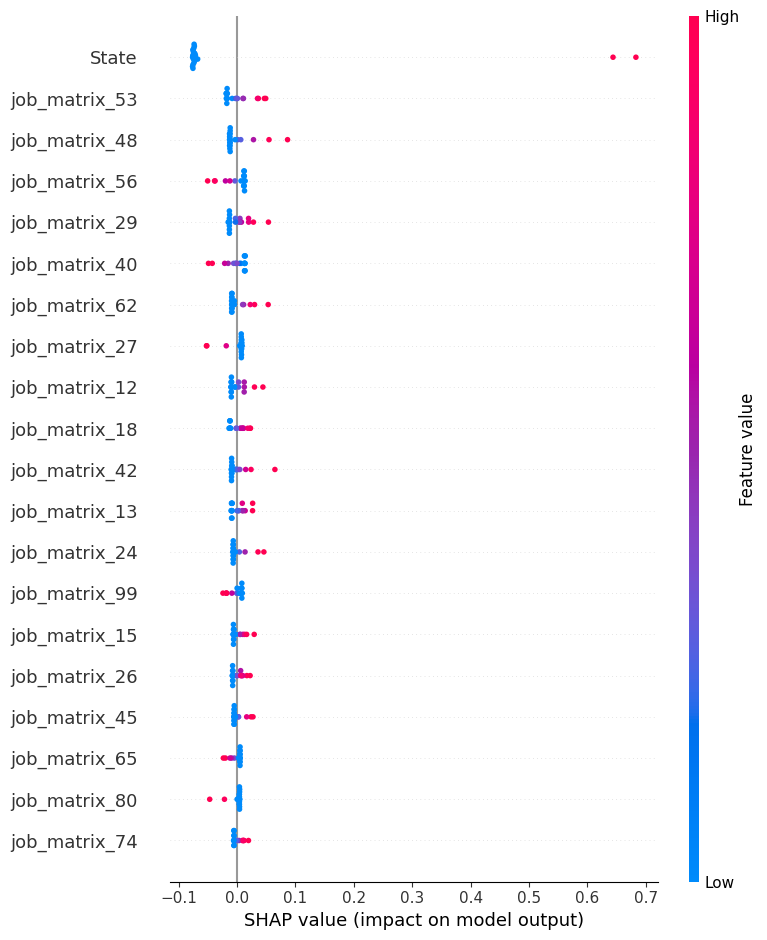

In [49]:
shap.summary_plot(shap_values_logreg, X_rec)

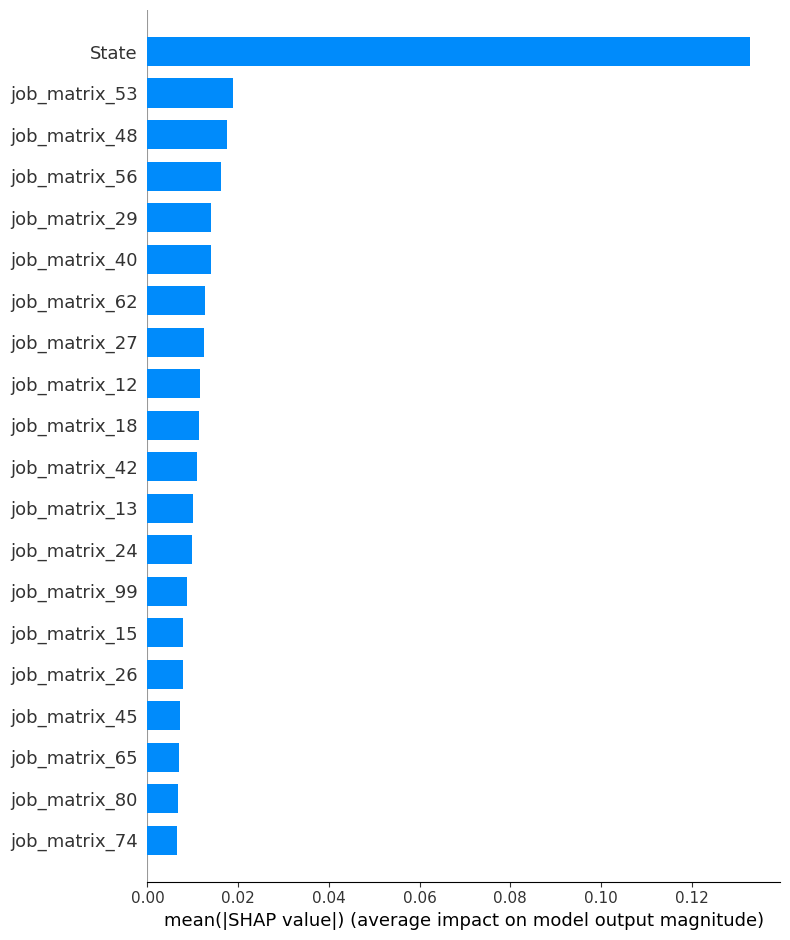

In [50]:
shap.summary_plot(shap_values_logreg, X_rec, plot_type = 'bar')

In [51]:
# Wrap all in a function
def get_shap_df(shap_sample_result):
    shap_values_df = pd.DataFrame(shap_sample_result)
    shap_values_df.columns = X_rec.columns
    # Combine recommendation and shap values into one dataset
    shap_explanation_df = pd.concat([rec_data, shap_values_df], axis=1)
    return shap_explanation_df

In [52]:
# Extract shap values 
shap_values_df = get_shap_df(shap_sample_result = shap_values_logreg)


In [53]:
shap_values_df.head()

UserID   JobID    Y_prob  Y_pred  rank  City     State  Country  \
0      13  248446  0.970798       1     0   0.0  0.643974      0.0   
1      13  367918  0.937227       1     1   0.0  0.683187      0.0   
2      13  580991  0.445008       0     2   0.0 -0.067560      0.0   
3      13  172155  0.351762       0     3   0.0 -0.071367      0.0   
4      13  799192  0.340405       0     4   0.0 -0.071798      0.0   

   DegreeType  WorkHistoryCount  ...  job_matrix_90  job_matrix_91  \
0         0.0               0.0  ...       0.001974       0.000000   
1         0.0               0.0  ...       0.000000      -0.002912   
2         0.0               0.0  ...       0.002605       0.003828   
3         0.0               0.0  ...       0.002307      -0.003013   
4         0.0               0.0  ...       0.002196       0.003104   

   job_matrix_92  job_matrix_93  job_matrix_94  job_matrix_95  job_matrix_96  \
0       0.000450      -0.018226       0.002985       0.001538       0.003325   
1      -0.060373       0.000000      -0.001701       0.000000       0.000000   
2       0.004110       0.000859      -0.001634       0.003589       0.002548   
3       0.003717       0.001034      -0.001676       0.003153       0.005922   
4       0.003684       0.001109       0.006548       0.003295      -0.005334   

   job_matrix_97  job_matrix_98  job_matrix_99  
0       0.000259      -0.000800       0.004449  
1       0.000000       0.000000       0.000000  
2       0.013112       0.000455       0.008829  
3      -0.003384       0.000255       0.008162  
4      -0.003093       0.000212      -0.024223  

[5 rows x 164 columns]

In [54]:
shap_values_df.to_csv(f'./nb_xai_viz/usecase_tfidf_logreg_shap_values_uid{test_uid}.csv', header=True, index=False)

### Show individual explanation only for predicted label = 1

In [55]:
positive_item_idx = shap_values_df[shap_values_df.Y_pred==1].index.values

In [56]:
positive_item_idx

array([0, 1])

In [57]:
for i in positive_item_idx:
    print('Visualization for single recommendation - positive interaction')
    shap.force_plot(explainer.expected_value, shap_values_logreg[i], X_rec.iloc[i,:])

Visualization for single recommendation - positive interaction
Visualization for single recommendation - positive interaction


### First recommended job

In [58]:
# First recommended job:
shap.force_plot(explainer.expected_value, shap_values_logreg[positive_item_idx[0]], X_rec.iloc[0,:])

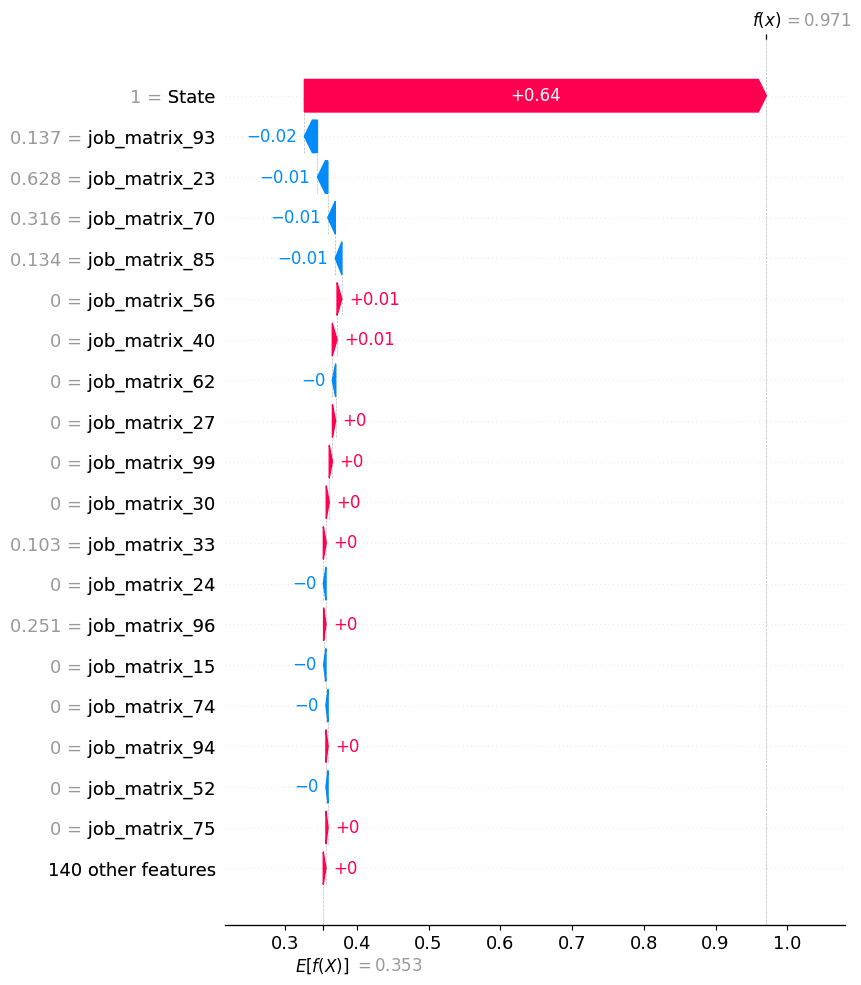

In [59]:
# Plot the SHAP waterfall for the single prediction
shap.waterfall_plot(shap.Explanation(values=shap_values_logreg[positive_item_idx[0]], 
#                                      base_values=np.mean(shap_values_logreg[positive_item_idx[0]]),
                                     base_values = explainer.expected_value,
                                     data=X_rec.iloc[0,:]),
                                    max_display = 20)

In [ ]:
# # Second recommended job:
# shap.force_plot(explainer.expected_value, shap_values_logreg[positive_item_idx[1]], X_rec.iloc[0,:])

In [ ]:
# # Plot the SHAP waterfall for the single prediction
# shap.waterfall_plot(shap.Explanation(values=shap_values_logreg[positive_item_idx[1]], 
#                                      base_values=np.mean(shap_values_logreg[positive_item_idx[1]]), 
#                                      data=X_rec.iloc[0,:]))

# Extract feature name for the local prediction

### Get list of top features based on shap values

In [60]:
# Get feature names for a single prediction: Should be the same as the waterfall plot
# i: index of the positive item
def get_shap_features_name_single(all_shap_values, i, n):
    single_prediction_shap_values = all_shap_values[i, :]
    feature_names = X_rec.columns

    # Calculate the absolute mean of the SHAP values
    abs_shap_values = np.abs(all_shap_values[i, :])

    # Get the indices of the top n features based on the absolute SHAP values
    top_n_indices = abs_shap_values.argsort()[-n:][::-1]

    # Get the names of the top n features
    top_n_feature_names = [feature_names[j] for j in top_n_indices]
    return top_n_feature_names

In [61]:
# First recommendation:
top20_shap_features_job1 = get_shap_features_name_single(all_shap_values = shap_values_logreg, 
                              i = positive_item_idx[0], 
                              n = 20)

In [62]:
top20_shap_features_job1 # Should match to the waterfall plot

['State',
 'job_matrix_93',
 'job_matrix_23',
 'job_matrix_70',
 'job_matrix_85',
 'job_matrix_56',
 'job_matrix_40',
 'job_matrix_62',
 'job_matrix_27',
 'job_matrix_99',
 'job_matrix_30',
 'job_matrix_33',
 'job_matrix_24',
 'job_matrix_96',
 'job_matrix_15',
 'job_matrix_74',
 'job_matrix_94',
 'job_matrix_52',
 'job_matrix_75',
 'job_matrix_29']

In [63]:
def get_job_matrix_idx(top_n_feature_names):
    job_matrix_list = top_n_feature_names
    job_matrix_idx = [int(item.split('_')[-1]) for item in job_matrix_list if item.startswith('job_matrix_')]
    return job_matrix_idx

In [64]:
job_matrix_idx_item1 = get_job_matrix_idx(top_n_feature_names = top20_shap_features_job1 )

In [65]:
# List of all job_matrix_index
job_matrix_idx_item1

[93, 23, 70, 85, 56, 40, 62, 27, 99, 30, 33, 24, 96, 15, 74, 94, 52, 75, 29]

### Convert feature from job_matrix_... to term

In [66]:
# function to get documents index for job corpus, given JobID
def get_doc_idx(j_id):
    job = job_set[job_set.JobID==j_id]
    j_idx = job.index.values[0]
    return j_idx

In [67]:
# WRAP ALL IN A FUNCTION

def get_term(job_id, job_matrix_index, job_set):
    # UserID = 13, JobID = 248446
    job_doc_idx = get_doc_idx(job_id)
    
    # Get the row of the TF-IDF matrix corresponding to the chosen document
    tfidf_row = tfidf_matrix[job_doc_idx, :]
    print('tf_idf row in the tf_idf_matrix: ', tfidf_row)
    print('len of this TF-IDF: ', tfidf_row.shape)

    # Convert the sparse row to a dense array for easier manipulation
    tfidf_array = tfidf_row.toarray()
    print('tf_idf array converted from tf_idf row: ', tfidf_array)
    
    # Get the indices of the word terms in the TF-IDF vectorizer
    word_term_indices = tf.get_feature_names_out()
    print('word_term_indices:', word_term_indices)
    print('len word_term_indices:', len(word_term_indices))
    
    # Retrieve specific word terms for all indices
    word_terms = [word_term_indices[i] for i in range(len(word_term_indices))]
    print('Retrieved word term', word_terms)
    print('Length word_terms:', len(word_terms))
    
    # Print the word terms and their corresponding TF-IDF values for the chosen document
    # Get final result (job_matrix_index, term, and tfidf value)
    result_idx = [] # Index in the job_index_matrix
    result_term = [] # Raw term from the original document
    result_tfidf = [] # TF-IDF from the job matrix
    for i, word_term in enumerate(word_terms):
        if i in job_matrix_index:
            tfidf_value = tfidf_array[0, i]
            print(f"Word Term: {word_term}, job_matrix_index {i}, TF-IDF Value: {tfidf_value}")
            result_idx.append(i)
            result_term.append(word_term)
            result_tfidf.append(tfidf_value)
            #print(word_term)
    return result_idx, result_term, result_tfidf


In [68]:
job_id = shap_values_df.loc[positive_item_idx[0]].JobID

In [69]:
job_id

248446.0

In [70]:
%%time
result_idx, result_term, result_tfidf = get_term(job_id = job_id, 
                                                 job_matrix_index = job_matrix_idx_item1, 
                                                 job_set = job_set)

tf_idf row in the tf_idf_matrix:    (0, 73)	0.11435746962209006
  (0, 70)	0.3157347716997907
  (0, 22)	0.0593869917150808
  (0, 42)	0.05880864056517932
  (0, 93)	0.1368612010185867
  (0, 48)	0.14302206580681537
  (0, 82)	0.04867236258663833
  (0, 11)	0.05005360885500783
  (0, 33)	0.1029449704400235
  (0, 77)	0.10010989315854296
  (0, 86)	0.06771312228934637
  (0, 18)	0.04996306205883942
  (0, 44)	0.06030298312761361
  (0, 17)	0.06646606219941666
  (0, 78)	0.11281564899791646
  (0, 38)	0.10813334151862665
  (0, 68)	0.06092395920957241
  (0, 0)	0.13283237385285404
  (0, 53)	0.05863482933596916
  (0, 98)	0.24626749904276704
  (0, 26)	0.05123530368399027
  (0, 96)	0.25073643704922643
  (0, 88)	0.051123515096944794
  (0, 97)	0.10466072477509263
  (0, 29)	0.05405175932036177
  (0, 12)	0.13497152198673232
  (0, 85)	0.13372491589117333
  (0, 51)	0.059787679226524365
  (0, 41)	0.10023528725027339
  (0, 20)	0.2631522780904542
  (0, 63)	0.045681267587639365
  (0, 13)	0.06228777708330804
  (0, 23)

In [71]:
len(result_idx), len(result_term), len(result_tfidf)

(19, 19, 19)

In [72]:
result_term

['customer service',
 'education',
 'employees',
 'equal',
 'excellent',
 'experience',
 'high',
 'job',
 'new',
 'opportunity',
 'plus',
 'program',
 'related',
 'required',
 'solutions',
 'technology',
 'time',
 'work',
 'years']

In [73]:
result_idx

[15, 23, 24, 27, 29, 30, 33, 40, 52, 56, 62, 70, 74, 75, 85, 93, 94, 96, 99]

In [74]:
# Convert result to dataframe
def get_result_df(result_idx, result_term, result_tfidf):
    result_df = pd.DataFrame(columns=['job_matrix_idx', 'term', 'tf_idf'])
    result_df.job_matrix_idx = result_idx
    result_df.term = result_term
    result_df.tf_idf = result_tfidf
    return result_df

In [75]:
result_df = get_result_df(result_idx = result_idx, 
                                    result_term = result_term, 
                                    result_tfidf = result_tfidf)

In [76]:
result_df

job_matrix_idx              term    tf_idf
0               15  customer service  0.000000
1               23         education  0.628019
2               24         employees  0.000000
3               27             equal  0.000000
4               29         excellent  0.054052
5               30        experience  0.000000
6               33              high  0.102945
7               40               job  0.000000
8               52               new  0.000000
9               56       opportunity  0.000000
10              62              plus  0.000000
11              70           program  0.315735
12              74           related  0.000000
13              75          required  0.000000
14              85         solutions  0.133725
15              93        technology  0.136861
16              94              time  0.000000
17              96              work  0.250736
18              99             years  0.000000

In [162]:
# Sorted result term following the order as job index matrix
def sort_term_result(result_df, job_matrix_index):
    sorter = job_matrix_index
    result_df.job_matrix_idx = result_df.job_matrix_idx.astype("category")
    result_df.job_matrix_idx = result_df.job_matrix_idx.cat.set_categories(sorter, ordered=True)
    sorted_result_df = result_df.sort_values(['job_matrix_idx'])
    return sorted_result_df

In [164]:
sorted_result_df = sort_term_result(result_df = result_df,
                                   job_matrix_index = job_matrix_idx_item1)

In [79]:
sorted_result_df

job_matrix_idx              term    tf_idf
15             93        technology  0.136861
1              23         education  0.628019
11             70           program  0.315735
14             85         solutions  0.133725
9              56       opportunity  0.000000
7              40               job  0.000000
10             62              plus  0.000000
3              27             equal  0.000000
18             99             years  0.000000
5              30        experience  0.000000
6              33              high  0.102945
2              24         employees  0.000000
17             96              work  0.250736
0              15  customer service  0.000000
12             74           related  0.000000
16             94              time  0.000000
8              52               new  0.000000
13             75          required  0.000000
4              29         excellent  0.054052

In [80]:
def convert_feature_names(top20_shap_features, job_matrix_index, sorted_result_term):
    list1 = top20_shap_features.copy() # top 20 features extracted from SHAP values
    list2 = job_matrix_index # index extracted from "job_matrix_idx_[number]"
    list3 = sorted_result_term # term following the same order as job_matrix_index
    # Replace the "job_matrix_index" with the corresponding term
    for i in range(len(list1)):
        if list1[i].startswith('job_matrix_'):
            index = int(list1[i].split('_')[-1])
            if index in list2:
                term_index = list2.index(index)
                list1[i] = list3[term_index]
    return list1

In [81]:
converted_features_job1 = convert_feature_names(top20_shap_features = top20_shap_features_job1,
                                               job_matrix_index = list(sorted_result_df.job_matrix_idx.values),
                                               sorted_result_term = list(sorted_result_df.term.values))

In [82]:
converted_features_job1

['State',
 'technology',
 'education',
 'program',
 'solutions',
 'opportunity',
 'job',
 'plus',
 'equal',
 'years',
 'experience',
 'high',
 'employees',
 'work',
 'customer service',
 'related',
 'time',
 'new',
 'required',
 'excellent']

In [83]:
top20_shap_features_job1

['State',
 'job_matrix_93',
 'job_matrix_23',
 'job_matrix_70',
 'job_matrix_85',
 'job_matrix_56',
 'job_matrix_40',
 'job_matrix_62',
 'job_matrix_27',
 'job_matrix_99',
 'job_matrix_30',
 'job_matrix_33',
 'job_matrix_24',
 'job_matrix_96',
 'job_matrix_15',
 'job_matrix_74',
 'job_matrix_94',
 'job_matrix_52',
 'job_matrix_75',
 'job_matrix_29']

### Plot the SHAP single explaination after converting features
- Force plot
- Waterfall plot

In [85]:
# First recommended job:
shap.force_plot(explainer.expected_value, 
                shap_values_logreg[positive_item_idx[0]], 
                X_rec.iloc[0,:],
               feature_names = converted_features_job1
               )

In [86]:
import shap
import pandas as pd

# shap_values is the SHAP values for the single case, and data is the corresponding single case data.
shap_values = shap_values_logreg[positive_item_idx[0]]
data = X_rec.iloc[0,:]

# Convert the single case data to a DataFrame and set the feature names
feature_names_custom = top20_shap_features_job1
feature_names_original = converted_features_job1

# Create a dictionary to map original feature names to custom feature names
original_to_custom_mapping = dict(zip(feature_names_original, feature_names_custom))


In [87]:
# Replace the original feature names in the data with the custom feature names
data_renamed = data.rename(original_to_custom_mapping)

In [88]:
data_renamed

City                0.000000
State               1.000000
Country             1.000000
DegreeType          4.000000
WorkHistoryCount    6.000000
                      ...   
job_matrix_95       0.000000
job_matrix_96       0.250736
job_matrix_97       0.104661
job_matrix_98       0.246267
job_matrix_99       0.000000
Name: 0, Length: 159, dtype: float64

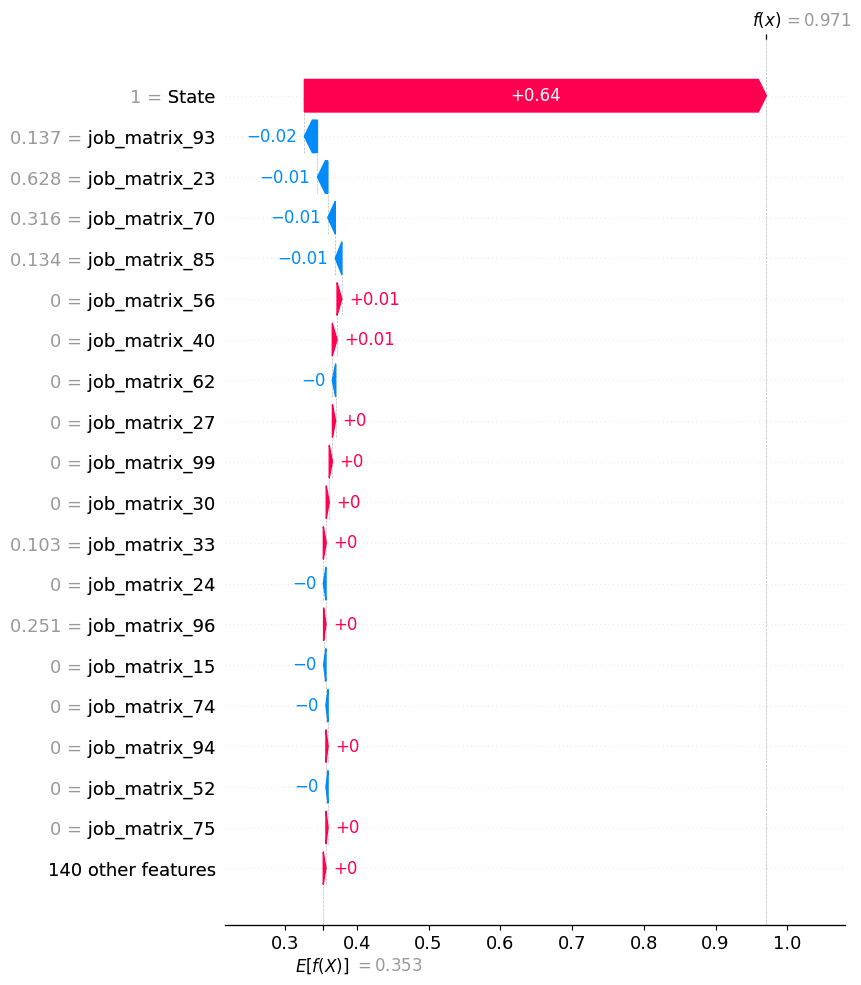

In [98]:
# Plot the SHAP waterfall for the single prediction
shap.waterfall_plot(shap.Explanation(values=shap_values, 
                                     # base_values=np.mean(shap_values),
                                     base_values = explainer.expected_value,
                                     data=data_renamed), 
                    max_display = 20)

In [99]:
def plot_shap_waterfall_text_feature(top20_shap_features, converted_feature_name, positive_single_item_index, shap_results, X_rec):
    '''
    top20_shap_features: list of top20 features from SHAP
    converted_feature_name: convert top20_shap_features to raw term
    postitive_item_index: index of item that you want to explain (item with predicted label 1)
    shap_results: shap_values generated by SHAP explainer
    X_rec: feature corresponding to 20 recommended jobs
    '''
    shap_values = shap_results[positive_single_item_index]
    data = X_rec.iloc[positive_single_item_index,:]
    
    # Convert the single case data to a DataFrame and set the feature names
    feature_names_custom = converted_feature_name
    feature_names_original = top20_shap_features

    # Create a dictionary to map original feature names to custom feature names
    original_to_custom_mapping = dict(zip(feature_names_original, feature_names_custom))

    # Replace the original feature names in the data with the custom feature names
    data_renamed = data.rename(original_to_custom_mapping)
    
    # Plot the SHAP waterfall for the single prediction
    shap.waterfall_plot(shap.Explanation(values=shap_values, 
                                         # base_values=np.mean(shap_values), 
                                         base_values = explainer.expected_value,
                                         data=data_renamed),
                        max_display = 20)
  

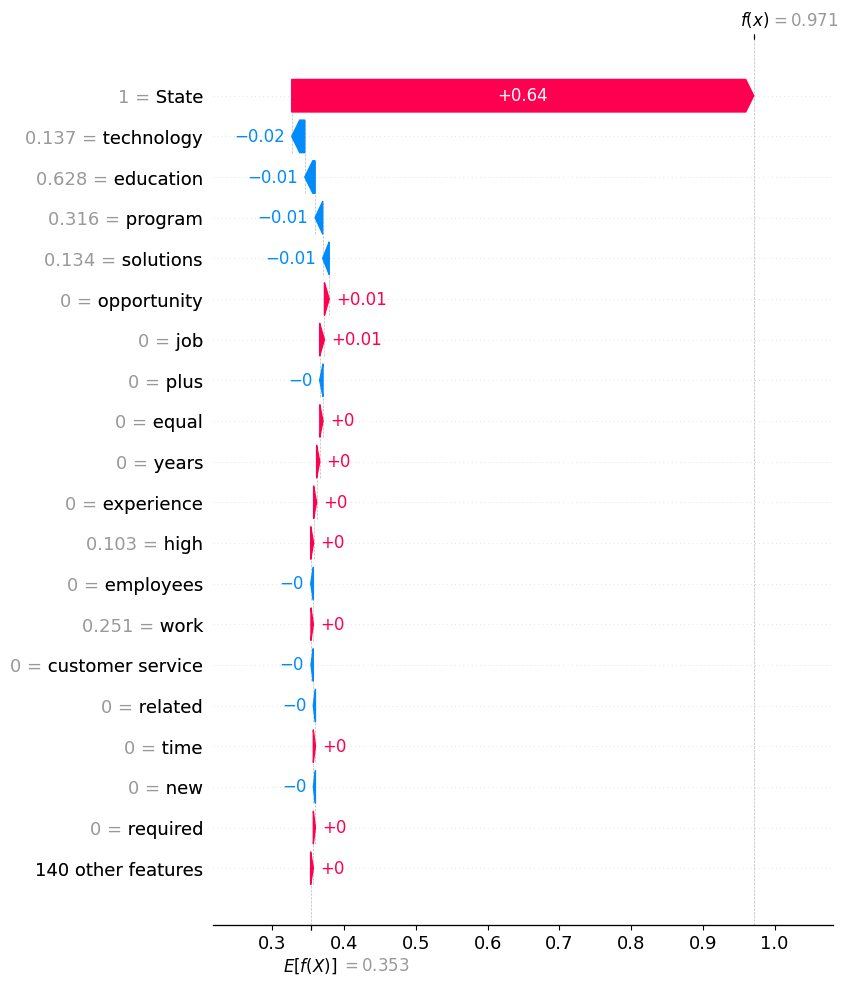

In [100]:
plot_shap_waterfall_text_feature(top20_shap_features = top20_shap_features_job1,
                                     converted_feature_name = converted_features_job1, 
                                     positive_single_item_index = positive_item_idx[0], 
                                     shap_results = shap_values_logreg, 
                                     X_rec = X_rec)

# LIME explainer using original LIME library

In [101]:
import lime
import lime.lime_tabular

In [102]:
# LIME has one explainer for all the models
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, 
                                                   feature_names=X_train.columns.values.tolist(), 
                                                   verbose=True, 
                                                   mode='classification')

In [103]:
import re
def split_by_multiple_delimiters(input_string, delimiters = ['<', '>', '<=', '>=']):
    # Create a regular expression pattern with the specified delimiters
    pattern = '|'.join(map(re.escape, delimiters))
    
    # Split the input string using the regular expression pattern
    parts = re.split(pattern, input_string)
    return parts

def contains_alphabet(input_string):
    # Use regular expression to check if the string contains any alphabet character
    pattern = r'[a-zA-Z]'
    match = re.search(pattern, input_string)
    return bool(match)

def convert_formatted_feature(formatted_feature_name):
    # Split the feature name
    parts = split_by_multiple_delimiters(formatted_feature_name)
    
    feature_name = None
    # Check in the list of terms and find the term containing alphabet character (=> feature)
    for term in parts:
        if contains_alphabet(term) == True:
            feature_name = term
    # Trim blank space in the feature
    feature_name = feature_name.strip()
    return feature_name

In [104]:
def extract_lime_weight_sample(lime_explainer, model, sample_data, num_features=20, random_state=None):
    """
    Extracts LIME weight scores for feature importance for a set of samples using an existing LIME explainer.

    Parameters:
        lime_explainer (lime.lime_tabular.LimeTabularExplainer): The pre-initialized LIME explainer.
        model (callable): The predictive model to be explained.
                          It should accept a 2D array-like input and return predictions.
        sample_data: The set of samples for which explanations will be generated.
        num_features (int): Number of top features to be returned for each sample.
        random_state (int or None): Random seed for reproducibility.

    Returns:
        List of dictionaries, where each dictionary contains:
            'sample_index': Index of the sample in the original data.
            'feature_names': List of feature_name for the top features (the feature name is converted to original feature name)
            'feature_importance_scores': List of feature_importance for the top features.
    """
    np.random.seed(random_state)

    lime_weight_scores = []

    for idx in range(len(sample_data)):
        explanation = lime_explainer.explain_instance(sample_data.values[idx], 
                                      model.predict_proba, 
                                      num_features=20)
        
        feature_names, feature_importance_scores = zip(*explanation.as_list())
        
        # Preprocess feature names to extract only the original feature name without the range information
        feature_names = [convert_formatted_feature(name) for name in feature_names]
        
        lime_weight_scores.append({
            'sample_index': idx,
            'feature_names': list(feature_names),
            'feature_importance_scores': list(feature_importance_scores)
        })

    return lime_weight_scores

In [105]:
%%time
lime_weight_scores = extract_lime_weight_sample(lime_explainer = lime_explainer, 
                           model = logreg, 
                           sample_data = X_rec, 
                           num_features=20, 
                           random_state=100)

Intercept 0.16233818970154895
Prediction_local [0.97938965]
Right: 0.9707982709870885
Intercept 0.2028044331096827
Prediction_local [0.91567344]
Right: 0.9372268618516721
Intercept 0.9312420226062652
Prediction_local [0.24571727]
Right: 0.4450081158165002
Intercept 0.9768982034742186
Prediction_local [0.16302137]
Right: 0.3517619957650638
Intercept 0.9245292404101028
Prediction_local [0.22397177]
Right: 0.3404051810963867
Intercept 0.9849880455665418
Prediction_local [0.19934128]
Right: 0.3218210627111159
Intercept 0.9248377694824562
Prediction_local [0.22217963]
Right: 0.319501131231008
Intercept 0.9165912123396813
Prediction_local [0.26681949]
Right: 0.3099689367288884
Intercept 0.9197402737049521
Prediction_local [0.24822425]
Right: 0.3050320114461424
Intercept 0.9549316314510912
Prediction_local [0.22064065]
Right: 0.289789278255334
Intercept 0.9433742184064265
Prediction_local [0.18419013]
Right: 0.2779876233913631
Intercept 0.9629961688317631
Prediction_local [0.19022979]
Right: 

In [106]:
# Convert feature weights from LIME to dataframe
lime_value_df = pd.DataFrame(columns = ['sample_index', 'feature_names', 'feature_importance_scores'])
for i in range(2):
    temp_df = pd.DataFrame(lime_weight_scores[i])
    lime_value_df = pd.concat([lime_value_df, temp_df], axis=0)
    
lime_value_df

sample_index      feature_names  feature_importance_scores
0             0              State                   0.755543
1             0               City                  -0.249749
2             0       job_matrix_7                   0.038396
3             0      job_matrix_80                   0.036823
4             0      job_matrix_57                   0.029598
5             0      job_matrix_87                   0.029055
6             0      job_matrix_34                   0.026612
7             0      job_matrix_93                  -0.023687
8             0         DegreeType                   0.020665
9             0      job_matrix_92                   0.020621
10            0       job_matrix_8                   0.019521
11            0      job_matrix_55                   0.018378
12            0      job_matrix_27                   0.017685
13            0      job_matrix_43                   0.015692
14            0      job_matrix_56                   0.015675
15            0      job_matrix_79                   0.015537
16            0      job_matrix_12                   0.015395
17            0      job_matrix_19                   0.015200
18            0      job_matrix_48                   0.013506
19            0     work_matrix_28                  -0.013416
0             1              State                   0.756536
1             1               City                  -0.238722
2             1       job_matrix_7                   0.040617
3             1      job_matrix_80                   0.037816
4             1      job_matrix_34                   0.026453
5             1      job_matrix_87                   0.024451
6             1      job_matrix_93                   0.024003
7             1      job_matrix_40                  -0.023320
8             1      job_matrix_53                  -0.022846
9             1      job_matrix_57                   0.022804
10            1       job_matrix_8                   0.021575
11            1      job_matrix_48                  -0.020937
12            1       job_matrix_5                   0.020827
13            1      job_matrix_92                  -0.020746
14            1      job_matrix_56                  -0.020585
15            1      job_matrix_55                   0.019343
16            1      job_matrix_79                   0.016509
17            1         DegreeType                   0.016492
18            1  CurrentlyEmployed                   0.016306
19            1      job_matrix_31                   0.016292

In [107]:
lime_weight_df = pd.DataFrame(lime_weight_scores)

In [108]:
lime_weight_df

sample_index                                      feature_names  \
0              0  [State, City, job_matrix_7, job_matrix_80, job...   
1              1  [State, City, job_matrix_7, job_matrix_80, job...   
2              2  [State, City, job_matrix_80, job_matrix_7, job...   
3              3  [State, City, job_matrix_80, job_matrix_7, job...   
4              4  [State, City, job_matrix_7, job_matrix_80, job...   
5              5  [State, City, job_matrix_7, job_matrix_80, job...   
6              6  [State, City, job_matrix_7, job_matrix_80, job...   
7              7  [State, City, job_matrix_7, job_matrix_80, job...   
8              8  [State, City, job_matrix_7, job_matrix_80, job...   
9              9  [State, City, job_matrix_7, job_matrix_80, job...   
10            10  [State, City, job_matrix_7, job_matrix_80, job...   
11            11  [State, City, job_matrix_7, job_matrix_80, job...   
12            12  [State, City, job_matrix_7, job_matrix_80, job...   
13            13  [State, City, job_matrix_7, job_matrix_80, job...   
14            14  [State, City, job_matrix_7, job_matrix_80, job...   
15            15  [State, City, job_matrix_7, job_matrix_80, job...   
16            16  [State, City, job_matrix_7, job_matrix_80, job...   
17            17  [State, City, job_matrix_80, job_matrix_7, job...   
18            18  [State, City, job_matrix_7, job_matrix_80, job...   
19            19  [State, City, job_matrix_7, job_matrix_80, job...   

                            feature_importance_scores  
0   [0.7555433145289375, -0.24974890561664143, 0.0...  
1   [0.7565362072642586, -0.23872176641708462, 0.0...  
2   [-0.7525523851588571, -0.23965126631935585, 0....  
3   [-0.7552986787850965, -0.23028569976545404, -0...  
4   [-0.7476783078856398, -0.24529185410161736, 0....  
5   [-0.7558968864700171, -0.24502634614208288, 0....  
6   [-0.7578895129453694, -0.25664020766288154, 0....  
7   [-0.7513736034465968, -0.23650728906589447, 0....  
8   [-0.753460163207421, -0.2328986078723876, 0.03...  
9   [-0.7537535063166528, -0.24534087237601054, 0....  
10  [-0.7556736814397496, -0.24383082881738233, 0....  
11  [-0.752129995278279, -0.223386890304217, 0.041...  
12  [-0.7523465492871276, -0.250906011034536, 0.04...  
13  [-0.7565459059755647, -0.2395415446974749, 0.0...  
14  [-0.752740793194317, -0.24609683865825446, 0.0...  
15  [-0.755153523517853, -0.23208353536687912, 0.0...  
16  [-0.7574637807621508, -0.23070071619805615, 0....  
17  [-0.7535937919134367, -0.23826791205286899, 0....  
18  [-0.7548748299179674, -0.241888094825701, 0.03...  
19  [-0.7516494805230094, -0.23756356844008644, 0....

In [109]:
# Combine recommendation and shap values into one dataset
lime_explanation_df = pd.concat([rec_data, lime_weight_df], axis=1)

In [110]:
lime_explanation_df

UserID    JobID    Y_prob  Y_pred  rank  sample_index  \
0       13   248446  0.970798       1     0             0   
1       13   367918  0.937227       1     1             1   
2       13   580991  0.445008       0     2             2   
3       13   172155  0.351762       0     3             3   
4       13   799192  0.340405       0     4             4   
5       13   241804  0.321821       0     5             5   
6       13   872594  0.319501       0     6             6   
7       13   876016  0.309969       0     7             7   
8       13   602061  0.305032       0     8             8   
9       13   979883  0.289789       0     9             9   
10      13  1100319  0.277988       0    10            10   
11      13   491220  0.275157       0    11            11   
12      13   824471  0.260717       0    12            12   
13      13   641999  0.256119       0    13            13   
14      13   864858  0.242136       0    14            14   
15      13   259223  0.241876       0    15            15   
16      13   568514  0.239257       0    16            16   
17      13   741104  0.233798       0    17            17   
18      13   198371  0.223575       0    18            18   
19      13   134765  0.221879       0    19            19   

                                        feature_names  \
0   [State, City, job_matrix_7, job_matrix_80, job...   
1   [State, City, job_matrix_7, job_matrix_80, job...   
2   [State, City, job_matrix_80, job_matrix_7, job...   
3   [State, City, job_matrix_80, job_matrix_7, job...   
4   [State, City, job_matrix_7, job_matrix_80, job...   
5   [State, City, job_matrix_7, job_matrix_80, job...   
6   [State, City, job_matrix_7, job_matrix_80, job...   
7   [State, City, job_matrix_7, job_matrix_80, job...   
8   [State, City, job_matrix_7, job_matrix_80, job...   
9   [State, City, job_matrix_7, job_matrix_80, job...   
10  [State, City, job_matrix_7, job_matrix_80, job...   
11  [State, City, job_matrix_7, job_matrix_80, job...   
12  [State, City, job_matrix_7, job_matrix_80, job...   
13  [State, City, job_matrix_7, job_matrix_80, job...   
14  [State, City, job_matrix_7, job_matrix_80, job...   
15  [State, City, job_matrix_7, job_matrix_80, job...   
16  [State, City, job_matrix_7, job_matrix_80, job...   
17  [State, City, job_matrix_80, job_matrix_7, job...   
18  [State, City, job_matrix_7, job_matrix_80, job...   
19  [State, City, job_matrix_7, job_matrix_80, job...   

                            feature_importance_scores  
0   [0.7555433145289375, -0.24974890561664143, 0.0...  
1   [0.7565362072642586, -0.23872176641708462, 0.0...  
2   [-0.7525523851588571, -0.23965126631935585, 0....  
3   [-0.7552986787850965, -0.23028569976545404, -0...  
4   [-0.7476783078856398, -0.24529185410161736, 0....  
5   [-0.7558968864700171, -0.24502634614208288, 0....  
6   [-0.7578895129453694, -0.25664020766288154, 0....  
7   [-0.7513736034465968, -0.23650728906589447, 0....  
8   [-0.753460163207421, -0.2328986078723876, 0.03...  
9   [-0.7537535063166528, -0.24534087237601054, 0....  
10  [-0.7556736814397496, -0.24383082881738233, 0....  
11  [-0.752129995278279, -0.223386890304217, 0.041...  
12  [-0.7523465492871276, -0.250906011034536, 0.04...  
13  [-0.7565459059755647, -0.2395415446974749, 0.0...  
14  [-0.752740793194317, -0.24609683865825446, 0.0...  
15  [-0.755153523517853, -0.23208353536687912, 0.0...  
16  [-0.7574637807621508, -0.23070071619805615, 0....  
17  [-0.7535937919134367, -0.23826791205286899, 0....  
18  [-0.7548748299179674, -0.241888094825701, 0.03...  
19  [-0.7516494805230094, -0.23756356844008644, 0....

## LIME PLOT on single prediction (item with positive predicted label)

In [111]:
# Check with an individual prediction (first job with predicted label 1)
random_state=100
np.random.seed(random_state)
j = positive_item_idx[0]
exp = lime_explainer.explain_instance(X_rec.loc[j], 
                                      logreg.predict_proba, 
                                      num_features=20)

Intercept 0.16233818970154895
Prediction_local [0.97938965]
Right: 0.9707982709870885


In [193]:
# Show the predictions
exp.show_in_notebook(show_table=True)

In [113]:
# Raw explaination by LIME
exp.as_list()

[('0.00 < State <= 1.00', 0.7555433145289375),
 ('City <= 0.00', -0.24974890561664143),
 ('job_matrix_7 <= 0.00', 0.0383960085025175),
 ('job_matrix_80 <= 0.00', 0.03682331419380923),
 ('job_matrix_57 <= 0.00', 0.02959803526029651),
 ('job_matrix_87 <= 0.00', 0.02905533253371379),
 ('job_matrix_34 <= 0.00', 0.02661234942659129),
 ('job_matrix_93 > 0.00', -0.023687044391144472),
 ('3.00 < DegreeType <= 4.00', 0.020665302838104256),
 ('job_matrix_92 <= 0.00', 0.020621245297997415),
 ('job_matrix_8 <= 0.00', 0.01952065452546419),
 ('job_matrix_55 <= 0.00', 0.018377864715728717),
 ('job_matrix_27 <= 0.00', 0.01768460260543448),
 ('job_matrix_43 <= 0.00', 0.015692355054256795),
 ('job_matrix_56 <= 0.00', 0.01567486492488455),
 ('job_matrix_79 <= 0.00', 0.01553666615959972),
 ('job_matrix_12 > 0.10', 0.015395478068027773),
 ('job_matrix_19 <= 0.00', 0.015200112453487336),
 ('job_matrix_48 > 0.00', 0.013505988738991639),
 ('work_matrix_28 <= 0.00', -0.013416077766228425)]

In [114]:
lime_single_explanation = pd.DataFrame(lime_weight_scores[j])

In [115]:
lime_single_explanation

sample_index   feature_names  feature_importance_scores
0              0           State                   0.755543
1              0            City                  -0.249749
2              0    job_matrix_7                   0.038396
3              0   job_matrix_80                   0.036823
4              0   job_matrix_57                   0.029598
5              0   job_matrix_87                   0.029055
6              0   job_matrix_34                   0.026612
7              0   job_matrix_93                  -0.023687
8              0      DegreeType                   0.020665
9              0   job_matrix_92                   0.020621
10             0    job_matrix_8                   0.019521
11             0   job_matrix_55                   0.018378
12             0   job_matrix_27                   0.017685
13             0   job_matrix_43                   0.015692
14             0   job_matrix_56                   0.015675
15             0   job_matrix_79                   0.015537
16             0   job_matrix_12                   0.015395
17             0   job_matrix_19                   0.015200
18             0   job_matrix_48                   0.013506
19             0  work_matrix_28                  -0.013416

In [116]:
lime_single_explanation['ABS_feature_importance_score'] = lime_single_explanation['feature_importance_scores'].abs()


In [117]:
lime_single_explanation

sample_index   feature_names  feature_importance_scores  \
0              0           State                   0.755543   
1              0            City                  -0.249749   
2              0    job_matrix_7                   0.038396   
3              0   job_matrix_80                   0.036823   
4              0   job_matrix_57                   0.029598   
5              0   job_matrix_87                   0.029055   
6              0   job_matrix_34                   0.026612   
7              0   job_matrix_93                  -0.023687   
8              0      DegreeType                   0.020665   
9              0   job_matrix_92                   0.020621   
10             0    job_matrix_8                   0.019521   
11             0   job_matrix_55                   0.018378   
12             0   job_matrix_27                   0.017685   
13             0   job_matrix_43                   0.015692   
14             0   job_matrix_56                   0.015675   
15             0   job_matrix_79                   0.015537   
16             0   job_matrix_12                   0.015395   
17             0   job_matrix_19                   0.015200   
18             0   job_matrix_48                   0.013506   
19             0  work_matrix_28                  -0.013416   

    ABS_feature_importance_score  
0                       0.755543  
1                       0.249749  
2                       0.038396  
3                       0.036823  
4                       0.029598  
5                       0.029055  
6                       0.026612  
7                       0.023687  
8                       0.020665  
9                       0.020621  
10                      0.019521  
11                      0.018378  
12                      0.017685  
13                      0.015692  
14                      0.015675  
15                      0.015537  
16                      0.015395  
17                      0.015200  
18                      0.013506  
19                      0.013416

In [118]:
sorted_lime_single_explanation = lime_single_explanation.sort_values(['ABS_feature_importance_score'], ascending=False)

In [119]:
sorted_lime_single_explanation

sample_index   feature_names  feature_importance_scores  \
0              0           State                   0.755543   
1              0            City                  -0.249749   
2              0    job_matrix_7                   0.038396   
3              0   job_matrix_80                   0.036823   
4              0   job_matrix_57                   0.029598   
5              0   job_matrix_87                   0.029055   
6              0   job_matrix_34                   0.026612   
7              0   job_matrix_93                  -0.023687   
8              0      DegreeType                   0.020665   
9              0   job_matrix_92                   0.020621   
10             0    job_matrix_8                   0.019521   
11             0   job_matrix_55                   0.018378   
12             0   job_matrix_27                   0.017685   
13             0   job_matrix_43                   0.015692   
14             0   job_matrix_56                   0.015675   
15             0   job_matrix_79                   0.015537   
16             0   job_matrix_12                   0.015395   
17             0   job_matrix_19                   0.015200   
18             0   job_matrix_48                   0.013506   
19             0  work_matrix_28                  -0.013416   

    ABS_feature_importance_score  
0                       0.755543  
1                       0.249749  
2                       0.038396  
3                       0.036823  
4                       0.029598  
5                       0.029055  
6                       0.026612  
7                       0.023687  
8                       0.020665  
9                       0.020621  
10                      0.019521  
11                      0.018378  
12                      0.017685  
13                      0.015692  
14                      0.015675  
15                      0.015537  
16                      0.015395  
17                      0.015200  
18                      0.013506  
19                      0.013416

In [120]:
sorted_lime_single_explanation.to_csv(f'./nb_xai_viz/logreg_lime_sorted_values_uid{test_uid}.csv', index=False, header=True)

In [121]:
top20_lime_features_job1 = sorted_lime_single_explanation.feature_names.values

In [122]:
top20_lime_features_job1

array(['State', 'City', 'job_matrix_7', 'job_matrix_80', 'job_matrix_57',
       'job_matrix_87', 'job_matrix_34', 'job_matrix_93', 'DegreeType',
       'job_matrix_92', 'job_matrix_8', 'job_matrix_55', 'job_matrix_27',
       'job_matrix_43', 'job_matrix_56', 'job_matrix_79', 'job_matrix_12',
       'job_matrix_19', 'job_matrix_48', 'work_matrix_28'], dtype=object)

In [123]:
job_matrix_lime_job1 = get_job_matrix_idx(top_n_feature_names = top20_lime_features_job1)

In [124]:
job_matrix_lime_job1

[7, 80, 57, 87, 34, 93, 92, 8, 55, 27, 43, 56, 79, 12, 19, 48]

In [125]:
%%time
result_lime_idx, result_lime_term, result_lime_tfidf = get_term(job_id = job_id, 
                                                 job_matrix_index = job_matrix_lime_job1, 
                                                 job_set = job_set)

tf_idf row in the tf_idf_matrix:    (0, 73)	0.11435746962209006
  (0, 70)	0.3157347716997907
  (0, 22)	0.0593869917150808
  (0, 42)	0.05880864056517932
  (0, 93)	0.1368612010185867
  (0, 48)	0.14302206580681537
  (0, 82)	0.04867236258663833
  (0, 11)	0.05005360885500783
  (0, 33)	0.1029449704400235
  (0, 77)	0.10010989315854296
  (0, 86)	0.06771312228934637
  (0, 18)	0.04996306205883942
  (0, 44)	0.06030298312761361
  (0, 17)	0.06646606219941666
  (0, 78)	0.11281564899791646
  (0, 38)	0.10813334151862665
  (0, 68)	0.06092395920957241
  (0, 0)	0.13283237385285404
  (0, 53)	0.05863482933596916
  (0, 98)	0.24626749904276704
  (0, 26)	0.05123530368399027
  (0, 96)	0.25073643704922643
  (0, 88)	0.051123515096944794
  (0, 97)	0.10466072477509263
  (0, 29)	0.05405175932036177
  (0, 12)	0.13497152198673232
  (0, 85)	0.13372491589117333
  (0, 51)	0.059787679226524365
  (0, 41)	0.10023528725027339
  (0, 20)	0.2631522780904542
  (0, 63)	0.045681267587639365
  (0, 13)	0.06228777708330804
  (0, 23)

In [126]:
result_lime_df = get_result_df(result_idx = result_lime_idx, 
                                    result_term = result_lime_term, 
                                    result_tfidf = result_lime_tfidf)

In [127]:
result_lime_df

job_matrix_idx           term    tf_idf
0                7           care  0.000000
1                8         career  0.000000
2               12        company  0.134972
3               19         design  0.000000
4               27          equal  0.000000
5               34           home  0.000000
6               43           life  0.000000
7               48      marketing  0.143022
8               55  opportunities  0.000000
9               56    opportunity  0.000000
10              57        patient  0.000000
11              79         retail  0.000000
12              80          sales  0.000000
13              87          store  0.000000
14              92      technical  0.000000
15              93     technology  0.136861

In [128]:
sorted_result_lime_df = sort_term_result(result_df = result_lime_df,
                                   job_matrix_index = job_matrix_lime_job1)

In [129]:
sorted_result_lime_df

job_matrix_idx           term    tf_idf
0               7           care  0.000000
12             80          sales  0.000000
10             57        patient  0.000000
13             87          store  0.000000
5              34           home  0.000000
15             93     technology  0.136861
14             92      technical  0.000000
1               8         career  0.000000
8              55  opportunities  0.000000
4              27          equal  0.000000
6              43           life  0.000000
9              56    opportunity  0.000000
11             79         retail  0.000000
2              12        company  0.134972
3              19         design  0.000000
7              48      marketing  0.143022

In [130]:
sorted_result_lime_df.to_csv(f'./nb_xai_viz/logreg_sorted_result_lime_df_uid{test_uid}.csv', header=True, index=False)

In [131]:
converted_features_lime_job1 = convert_feature_names(top20_shap_features = top20_lime_features_job1,
                                               job_matrix_index = list(sorted_result_lime_df.job_matrix_idx.values),
                                               sorted_result_term = list(sorted_result_lime_df.term.values))

In [132]:
converted_features_lime_job1

array(['State', 'City', 'care', 'sales', 'patient', 'store', 'home',
       'technology', 'DegreeType', 'technical', 'career', 'opportunities',
       'equal', 'life', 'opportunity', 'retail', 'company', 'design',
       'marketing', 'work_matrix_28'], dtype=object)

In [133]:
# Plot feature importance with converted feature
data = X_rec.iloc[0,:] # Slide the data

# Convert the single case data to a DataFrame and set the feature names
lime_feature_names_custom = converted_features_lime_job1
lime_feature_names_original = top20_lime_features_job1

# Create a dictionary to map original feature names to custom feature names
lime_original_to_custom_mapping = dict(zip(lime_feature_names_original, lime_feature_names_custom))


In [134]:
# Replace the original feature names in the data with the custom feature names
data_renamed_lime = data.rename(lime_original_to_custom_mapping)

In [135]:
data_renamed_lime.index.values

array(['City', 'State', 'Country', 'DegreeType', 'WorkHistoryCount',
       'TotalYearsExperience', 'CurrentlyEmployed', 'ManagedOthers',
       'ManagedHowMany', 'work_matrix_0', 'work_matrix_1',
       'work_matrix_2', 'work_matrix_3', 'work_matrix_4', 'work_matrix_5',
       'work_matrix_6', 'work_matrix_7', 'work_matrix_8', 'work_matrix_9',
       'work_matrix_10', 'work_matrix_11', 'work_matrix_12',
       'work_matrix_13', 'work_matrix_14', 'work_matrix_15',
       'work_matrix_16', 'work_matrix_17', 'work_matrix_18',
       'work_matrix_19', 'work_matrix_20', 'work_matrix_21',
       'work_matrix_22', 'work_matrix_23', 'work_matrix_24',
       'work_matrix_25', 'work_matrix_26', 'work_matrix_27',
       'work_matrix_28', 'work_matrix_29', 'work_matrix_30',
       'work_matrix_31', 'work_matrix_32', 'work_matrix_33',
       'work_matrix_34', 'work_matrix_35', 'work_matrix_36',
       'work_matrix_37', 'work_matrix_38', 'work_matrix_39',
       'work_matrix_40', 'work_matrix_41', 

In [136]:
data_renamed_features = list(data_renamed_lime.index.values)

In [137]:
data_renamed_features[60:70]

['job_matrix_1',
 'job_matrix_2',
 'job_matrix_3',
 'job_matrix_4',
 'job_matrix_5',
 'job_matrix_6',
 'care',
 'career',
 'job_matrix_9',
 'job_matrix_10']

In [138]:
# Create NEW Lime tabular explainer
random_state=100
np.random.seed(random_state)
new_lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, 
                                                   feature_names=data_renamed_features, 
                                                   verbose=True, 
                                                   mode='classification')

In [139]:
# Check with an individual prediction (first job with predicted label 1)
new_explanation = new_lime_explainer.explain_instance(data_renamed_lime, 
                                      logreg.predict_proba, 
                                      num_features=20)

Intercept 0.16233818970154895
Prediction_local [0.97938965]
Right: 0.9707982709870885


In [192]:
new_explanation.show_in_notebook(show_table=True)

In [141]:
logreg.predict(X_rec)

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [142]:
# Export some outputs for repport
rec_data_full.to_csv(f'./nb_xai_viz/usecase_recdata_logreg_uid{test_uid}.csv', header=True, index=False)

# Term extraction for WORK_history matrix. Show final explanation with full converted terms
If the top feature have work_matrix features. 

In [144]:
work_history_corpus = pd.read_csv('./nb_xai_viz/work_history_corpus.csv')

In [149]:
work_history_corpus.head()

UserID                                         Job_Titles
0       7  Front End Supervisor/CashierCustomer Service R...
1       9                             CookMechanicFile Clerk
2      13  Pennsylvania MentorStudent WorkerInternship in...
3      16  Senior Messaging Engineer (Exchange Lead)Excha...
4      26  Information Technology ManagerConsultantSuppor...

In [145]:
def get_work_history_idx(u_id):
    doc_history = work_history_corpus[work_history_corpus.UserID==u_id]
    u_idx = doc_history.index.values[0]
    return u_idx

In [146]:
def get_work_matrix_idx(top_n_feature_names):
    work_matrix_list = top_n_feature_names
    work_matrix_idx = [int(item.split('_')[-1]) for item in work_matrix_list if item.startswith('work_matrix_')]
    return work_matrix_idx

In [147]:
work_matrix_idx_job1 = get_work_matrix_idx(top20_lime_features_job1)

In [148]:
work_matrix_idx_job1

[28]

In [155]:
# WRAP ALL IN A FUNCTION

def get_user_term(u_id, work_matrix_index, work_history_corpus):
    # UserID = 13, JobID = 248446
    user_doc_idx = get_work_history_idx(u_id)
    
    # Get the row of the TF-IDF matrix corresponding to the chosen document
    tfidf_row = word_history_tf_matrix[work_matrix_index, :]
    print('tf_idf row in the tf_idf_matrix: ', tfidf_row)
    print('len of this TF-IDF: ', tfidf_row.shape)

    # Convert the sparse row to a dense array for easier manipulation
    tfidf_array = tfidf_row.toarray()
    print('tf_idf array converted from tf_idf row: ', tfidf_array)
    
    # Get the indices of the word terms in the TF-IDF vectorizer
    word_term_indices = word_history_tf.get_feature_names_out()
    print('word_term_indices:', word_term_indices)
    print('len word_term_indices:', len(word_term_indices))
    
    # Retrieve specific word terms for all indices
    word_terms = [word_term_indices[i] for i in range(len(word_term_indices))]
    print('Retrieved word term', word_terms)
    print('Length word_terms:', len(word_terms))
    
    # Print the word terms and their corresponding TF-IDF values for the chosen document
    # Get final result (job_matrix_index, term, and tfidf value)
    result_idx = [] # Index in the job_index_matrix
    result_term = [] # Raw term from the original document
    result_tfidf = [] # TF-IDF from the job matrix
    for i, word_term in enumerate(word_terms):
        if i in work_matrix_index:
            tfidf_value = tfidf_array[0, i]
            print(f"Word Term: {word_term}, user_matrix_index {i}, TF-IDF Value: {tfidf_value}")
            result_idx.append(i)
            result_term.append(word_term)
            result_tfidf.append(tfidf_value)
            #print(word_term)
    return result_idx, result_term, result_tfidf


In [156]:
%%time
result_lime_user_idx, result_lime_user_term, result_lime_user_tfidf = get_user_term(u_id = u_id, 
                                                 work_matrix_index = work_matrix_idx_job1, 
                                                 work_history_corpus = work_history_corpus)

tf_idf row in the tf_idf_matrix:    (0, 3)	0.7212833986545812
  (0, 40)	0.6926400644095722
len of this TF-IDF:  (1, 50)
tf_idf array converted from tf_idf row:  [[0.         0.         0.         0.7212834  0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.69264006 0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]]
word_term_indices: ['account' 'administrative' 'analyst' 'assistant' 'associate' 'business'
 'care' 'cashier' 'center' 'clerk' 'consultant' 'control' 'coordinator'
 'customer' 'customer service' 'data' 'desk' 'development' 'director'
 'engineer' 'entry' 'executive' 'financial' 'general' 'lead' 'management'
 'manager' 'marketing' 'm

In [165]:
# Convert result to dataframe
def get_result_df_user(result_idx, result_term, result_tfidf):
    result_df = pd.DataFrame(columns=['work_matrix_idx', 'term', 'tf_idf'])
    result_df.work_matrix_idx = result_idx
    result_df.term = result_term
    result_df.tf_idf = result_tfidf
    return result_df

In [166]:
# Sorted result term following the order as job index matrix
def sort_term_result_user(result_df, work_matrix_index):
    sorter = work_matrix_index
    result_df.work_matrix_idx = result_df.work_matrix_idx.astype("category")
    result_df.work_matrix_idx = result_df.work_matrix_idx.cat.set_categories(sorter, ordered=True)
    sorted_result_df = result_df.sort_values(['work_matrix_idx'])
    return sorted_result_df

In [167]:
result_lime_user_df = get_result_df_user(result_idx = result_lime_user_idx, 
                                    result_term = result_lime_user_term, 
                                    result_tfidf = result_lime_user_tfidf)

In [168]:
result_lime_user_df

work_matrix_idx     term  tf_idf
0               28  medical     0.0

In [170]:
sorted_result_lime_df_user = sort_term_result_user(result_df = result_lime_user_df,
                                   work_matrix_index = work_matrix_idx_job1)

In [171]:
sorted_result_lime_df_user

work_matrix_idx     term  tf_idf
0              28  medical     0.0

In [172]:
def convert_feature_names_final(converted_features_job, work_matrix_index, sorted_result_lime_df_user):
    list1 = converted_features_job.copy() # Converted features with job_matrix_index term
    list2 = work_matrix_index # index extracted from "work_matrix_idx_[number]"
    list3 = sorted_result_lime_df_user # term following the same order as work_matrix_index
    # Replace the "job_matrix_index" with the corresponding term
    for i in range(len(list1)):
        if list1[i].startswith('work_matrix_'):
            index = int(list1[i].split('_')[-1])
            if index in list2:
                term_index = list2.index(index)
                list1[i] = list3[term_index]
    return list1

In [174]:
converted_features_lime_job1

array(['State', 'City', 'care', 'sales', 'patient', 'store', 'home',
       'technology', 'DegreeType', 'technical', 'career', 'opportunities',
       'equal', 'life', 'opportunity', 'retail', 'company', 'design',
       'marketing', 'work_matrix_28'], dtype=object)

In [180]:
converted_features_lime_final = convert_feature_names_final(converted_features_job = converted_features_lime_job1,
                                                           work_matrix_index = list(sorted_result_lime_df_user.work_matrix_idx.values),
                                                           sorted_result_lime_df_user = list(sorted_result_lime_df_user.term.values))

In [181]:
converted_features_lime_final

array(['State', 'City', 'care', 'sales', 'patient', 'store', 'home',
       'technology', 'DegreeType', 'technical', 'career', 'opportunities',
       'equal', 'life', 'opportunity', 'retail', 'company', 'design',
       'marketing', 'medical'], dtype=object)

In [182]:
# Plot feature importance with converted feature
data = X_rec.iloc[0,:] # Slide the data

# Convert the single case data to a DataFrame and set the feature names
lime_feature_names_custom = converted_features_lime_final
lime_feature_names_original = top20_lime_features_job1

# Create a dictionary to map original feature names to custom feature names
lime_original_to_custom_mapping = dict(zip(lime_feature_names_original, lime_feature_names_custom))


In [185]:
# Replace the original feature names in the data with the custom feature names
data_renamed_lime_final = data.rename(lime_original_to_custom_mapping)
data_renamed_features_final = list(data_renamed_lime_final.index.values)

In [186]:
# Create FINAL Lime tabular explainer
random_state=100
np.random.seed(random_state)
final_lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, 
                                                   feature_names=data_renamed_features_final, 
                                                   verbose=True, 
                                                   mode='classification')

In [187]:
# Check with an individual prediction (first job with predicted label 1)
final_explanation = final_lime_explainer.explain_instance(data_renamed_lime_final, 
                                      logreg.predict_proba, 
                                      num_features=20)

Intercept 0.16233818970154895
Prediction_local [0.97938965]
Right: 0.9707982709870885


In [191]:
final_explanation.show_in_notebook(show_table=True)